<a href="https://colab.research.google.com/github/BhaskarKapri07/Learning-PyTorch/blob/main/Pytorch02_Workflow.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Pytorch Workflow

In [ ]:
what_were_covering = {
    1: "data (prepare and load)",
    2: "build model",
    3: "fitting the model to data (training)",
    4: "making predictions and evaluating a model (inference)",
    5: "saving and loading a model",
    6: "putting it all together"
}

what_were_covering

In [ ]:
import torch
from torch import nn    # nn contains all of PyTorche's building blocks for neural networks
import matplotlib.pyplot as plt

# Check PyTorch version
torch.__version__

'2.3.0+cu121'

## 1. Data Preparing and Loading

Data can be almost anything ... in machine learning
* Excel spredsheet
* Images of any kind
* Videos
* DNA
* Text

Machine learning is a game of two parts:
1. Get data into a numerical representations.
2. Build a model to learn patterns in that numerical representation.


To showcase this, let's create some *known* data using linear regression formula.

We'll use a linear regression formula to make a straight line as known **parameter**.

In [ ]:
# Create *known* parameters
weight = 0.7
bias = 0.3

# Create
start = 0
end = 1
step = 0.02
X = torch.arange(start, end, step).unsqueeze(dim=1)
y = weight * X + bias

X[:10], y[:10]

In [ ]:
 len(X), len(y)

### Splitting data into training and test sets

Let's create a training and test set with our data

In [ ]:
# Create a train/test split

train_split = int(0.8 *len(X))
X_train,y_train = X[:train_split], y[:train_split]
X_test, y_test = X[train_split:], y[train_split:]

len(X_train), len(y_train), len(X_test), len(y_test)


How might we better visualize our data?

This is where the data explorer's motto comes in!

"Visualize, visualize, visualize!"

In [ ]:
def plot_predictions(train_data=X_train,
                     train_labels=y_train,
                     test_data=X_test,
                     test_labels=y_test,
                     predictions=None):
  """
  Plots training data, test data and compares predictions.
  """
  plt.figure(figsize=(10, 7))

  # Plot training data in blue
  plt.scatter(train_data, train_labels, c="b", s=4, label="Training data")

  # Plot test data in green
  plt.scatter(test_data, test_labels, c="g", s=4, label="Test data")

  # Are there predictions?
  if predictions is not None:
    # Plot the predictions if they exist
    plt.scatter(test_data, predictions, c="r", s=4, label="Predictions")

  # Show the legend
  plt.legend(prop={"size": 14})

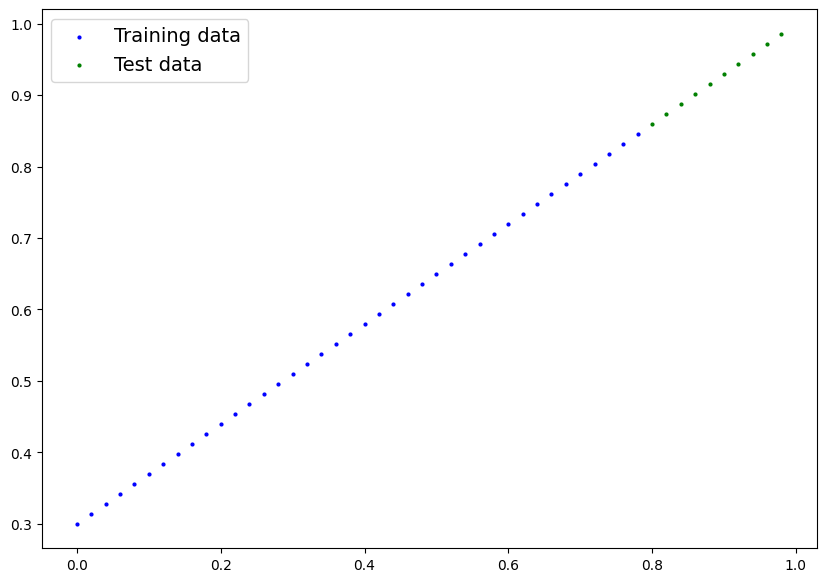

In [ ]:
plot_predictions()

## 2. Build model

Our first PyTorch model!

What our model does:
* Start with random values (weights & biases)
* Look at training data and adjust the random values to better represent (or get closer to) the ideal values ( the weight & bias values we used to create the data)


How does it do so?
Through two main algorithms:
1. Gradient Descent
2. Backpropagation

In [ ]:

from torch import nn

class LinearRegressionModel(nn.Module):
  def __init__(self):
    super().__init__()
    self.weights = nn.Parameter(torch.randn(1,
                                            requires_grad=True,
                                            dtype=torch.float))
    self.bias = nn.Parameter(torch.randn(1,
                                         requires_grad=True,
                                         dtype=torch.float))

  # Forward method to define the computation in the model
  def forward(self, x: torch.Tensor) -> torch.Tensor:
    return self.weights * x + self.bias

### PyTorch model building essentials

* torch.nn -> contains all the building blocks for computational graphs (a neural network can be considered a computational graph)
* torch.nn.Parameter -> what parameters should our model try and learn, often a PyTorch layer from torch.nn will set these for us
* torch.nn.Module -> The base class for all neural network modules, if you subclass it, you should overwrite forward()
* torch.optim -> this is where the optimizers in PyTorch live, they will help with gradient descent
* def forward() -> all nn.Module subclasses require you to overwrite forward(), this method defines what happens in the forward computation


### Checking the contents of our PyTorch Model

So we can check our model parameters or what's inside our model using `.parameters()`.

In [ ]:
# Create a random seed
torch.manual_seed(42)

# Creating an instance of the model
model_0 = LinearRegressionModel()

# Check out the parameters
list(model_0.parameters())

[Parameter containing:
 tensor([0.3367], requires_grad=True),
 Parameter containing:
 tensor([0.1288], requires_grad=True)]

In [ ]:
# List named parmeters
model_0.state_dict()

OrderedDict([('weights', tensor([0.3367])), ('bias', tensor([0.1288]))])

### Making predictions using `torch.inference_mode()`

To check our model's predictive power, let's see how well it predicts `y_test` based on `X_test`

When we pass data through out model, it's goinng to run it through the forward() method

In [ ]:
# Make predictions with model

with torch.inference_mode():
  y_preds = model_0(X_test)

y_preds

RuntimeError: Expected all tensors to be on the same device, but found at least two devices, cuda:0 and cpu!

In [ ]:
y_test

In [ ]:
plot_predictions(predictions=y_preds)

## 3. Train model

One way to measure how poor or how wrong your models predictions are is to use loss function

* Note: Loss functions may also be called cost functions or criterion in different areas.


Things we need to train:

* **Loss function:** A function to measure how wrng your model's predictions are to the ideal outputs, lower the better.
* **Optimizer:** Takes into account the loss of a model and adjusts the model's parameter(e.g., weights & bias) to improve the loss function

And specifically for PyTorch we need:
* A training loop
* A testing loop

In [ ]:
list(model_0.parameters())

In [ ]:
# Setup a loss function
loss_fn = nn.L1Loss()

# Setup an optmizer
optimizer = torch.optim.SGD(params=model_0.parameters(),
                            lr=0.01)

### Building a training loop (and a testing loop) in PyTorch

A couple of things we need in training loop:
0. Loop through the data and do...
1. Forward pass (this involves data moving through our model's `forward()` functions) to make predictions on data - also called forward propagation
2. Calculate the loss (compare forward pass predictions to ground truth labels)
3. Optimizer zero grad
4. Loss backward - move backwards through the network to calculate the gradients of each of the parameters of our model with respect to the loss (**backpropagation**)
5. Optimizer step - use the optimizer to adjust our model's parameters to try and improve the loss (**gradient descent**)
                 

In [ ]:
# An epoch is one loop through the data

epochs = 200

# Track different values
epoch_count = []
loss_values = []
test_loss_values = []

### Training
# 0. Loop through the data
for epoch in range(epochs):
  # Set the model to training mode
  model_0.train()   # train mode in PyTorch sets all parameters that requires gradients to require gradient

  # 1. Forward pass
  y_pred = model_0(X_train)

  # 2. Caluclate loss
  loss = loss_fn(y_pred, y_train)

  # 3. Optimizer zero grad
  optimizer.zero_grad()

  # 4. Perform backpropagation on the loss with respect to the parameters of the model
  loss.backward()

  # 5. Step the optimizer (perform gradient descent)
  optimizer.step()  # by default how the optmizer changes will accumulate through the loop so... we have to zero them above in step 3 for the next iteration of the loop


  #Testing
  model_0.eval()    # turns off different settings in the model not needed for evaluation/testing
  with torch.inference_mode():  # turns off gradient tracking & a couple more things behind the scenes
    # 1. Do the forward pass
    test_pred = model_0(X_test)

    # 2. Calculate the loss
    test_loss = loss_fn(test_pred, y_test)

  if epoch %10==0:
    epoch_count.append(epoch)
    loss_values.append(loss)
    test_loss_values.append(test_loss)
    print(f'Epoch: {epoch} | Train loss: {loss} | Test loss: {test_loss}')


    #  Print out model state_dict
    print(model_0.state_dict())


In [ ]:
import numpy as np
# Plot the loss curve
plt.plot(epoch_count, np.array(torch.tensor(loss_values).numpy()), label="Train loss")
plt.plot(epoch_count, test_loss_values, label="Test loss")
plt.title("Training and test loss curves")
plt.ylabel("loss")
plt.xlabel("epochs")
plt.legend()

In [ ]:
with torch.inference_mode():
  y_preds_new = model_0(X_test)

In [ ]:
model_0.state_dict()

In [ ]:
plot_predictions(predictions=y_preds)

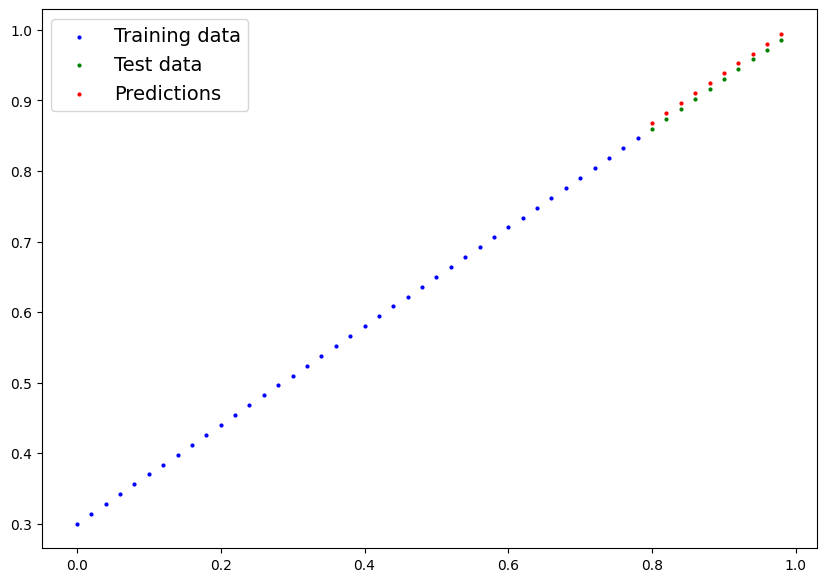

In [ ]:
plot_predictions(predictions=y_preds_new)

## Saving a model in PyTorch

There are 3 main methods for saving and loading models in PyTorch:
1. `torch.save` -> allows you to save PyTorch object in python's pickle format.
2. `torch.load` -> allows you to load a saved PyTorch model
3. `torch.nn.Module.load_state_dict()` -> this allows you to load a model's saved state dictionary

In [ ]:
# Saving our PyTorch Model
from pathlib import Path

# 1. Create model directory
MODEL_PATH = Path("models")
MODEL_PATH.mkdir(parents=True, exist_ok=True)

# 2. Create a model save path
MODEL_NAME = "01_pytorch_workflow_model_0.pth"
MODEL_SAVE_PATH = MODEL_PATH / MODEL_NAME

# 3. Save the model state dict
print(f'Saving model to " {MODEL_SAVE_PATH}')
torch.save(obj=model_0.state_dict(),
           f=MODEL_SAVE_PATH)

In [ ]:
!ls -l models

## Loading a pytorch model

Since we saved our model's `state_dict()` rather than the entire model, we'll create a new instance of our model class and load the saved `state_dict()` into that.

In [ ]:
loaded_model_0 = LinearRegressionModel()

# Load the saved state_dict of model_0 (this will update the new instance with updated parameters)
loaded_model_0.load_state_dict(torch.load(f=MODEL_SAVE_PATH))

In [ ]:
# Make some predictions with our loaded model

loaded_model_0.eval()
with torch.inference_mode():
  loaded_model_preds = loaded_model_0(X_test)

loaded_model_preds

In [ ]:
y_preds_new == loaded_model_preds

## 6. Putting it all together

All steps in one place

In [ ]:
# Import pytorch and matplotlib
import torch
from torch import nn
import matplotlib.pyplot as plt

# Check pytorch version
torch.__version__

'2.3.0+cu121'

Create device agnostic code.

In [ ]:
# Setup device agnostic code
device = "cuda" if torch.cuda.is_available() else "cpu"
print(f'Using device: {device}')

### 6.1 Data

In [ ]:
# Create some data usinf linear regression formula of y = weights * X+ bias

weight = 0.6
bias = 0.4

# Create range values
start = 0
end = 1
step = 0.02

# Create X and y (features and labels)
X = torch.arange(start,end,step).unsqueeze(dim=1)
y = weight * X + bias
X[:10], y[:10]

In [ ]:
# Split data
train_split = int(0.8*len(X))
X_train, y_train = X[:train_split], y[:train_split]
X_test, y_test = X[train_split:], y[train_split:]

len(X_train), len(y_train), len(X_test), len(y_test)

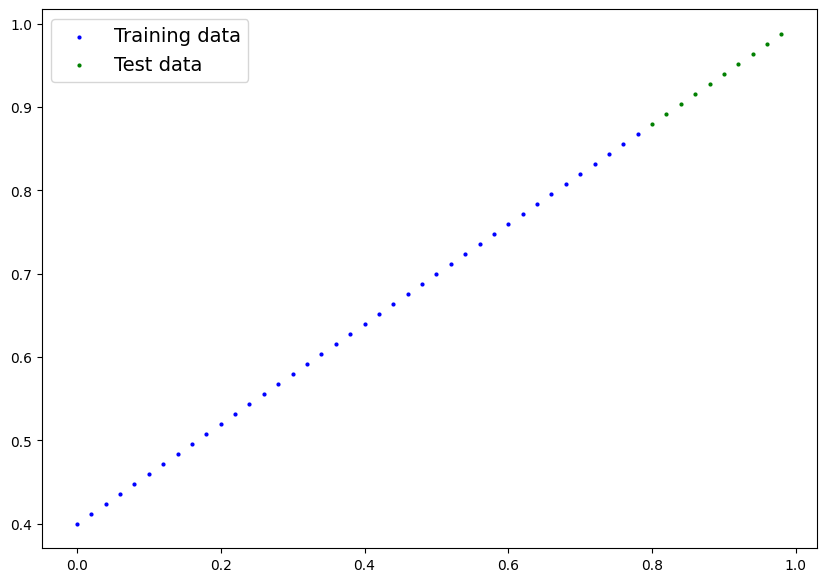

In [ ]:
# Plot the data
plot_predictions(X_train, y_train, X_test, y_test)

## 6.2 Building a PyTorch Linear Model


In [ ]:
# Create a linear model by subclassing nn.Module

class LinearRegressionModelV2(nn.Module):
  def __init__(self):
    super().__init__()
    # use nn.Linear() for creating the model parameters / also called linear transform, probing layer, fully connected layer, dense layer
    self.linear_layer = nn.Linear(in_features=1,
                                  out_features=1)

    # Forward method to define the computation in the model
  def forward(self, x: torch.Tensor) -> torch.Tensor:
    return self.linear_layer(x)


# set the manual seed
torch.manual_seed(42)
model_1 = LinearRegressionModelV2()
model_1, model_1.state_dict()

In [ ]:
# check the model current device
next(model_1.parameters()).device

In [ ]:
# set the model to use the target device
model_1.to(device)
next(model_1.parameters()).device

### 6.3 Training

For training we need :
* Loss function
* Optimizer
* Training Loop
* Testing Loop

In [ ]:
# Setup loss function

loss_fn = nn.L1Loss()

# Setup optimizer
optimizer = torch.optim.SGD(params=model_1.parameters(),
                            lr=0.01)

In [ ]:
# Training loop

torch.manual_seed(42)

epochs = 250

# Put data on the target device
X_train = X_train.to(device)
y_train = y_train.to(device)
X_test = X_test.to(device)
y_test = y_test.to(device)

for epoch in range(epochs):
  model_1.train()

  # 1. Forward pass
  y_pred = model_1(X_train)

  # 2. Calculate loss
  loss = loss_fn(y_pred, y_train)

  # 3. Optimizer zero grad
  optimizer.zero_grad()

  # 4. Perform backpropagation on the loss with respect to the parameters of the model
  loss.backward()

  # 5. Step the optimizer (perform gradient descent)
  optimizer.step()


  ### Testing
  model_1.eval()

  with torch.inference_mode():
    test_pred = model_1(X_test)
    test_loss = loss_fn(test_pred, y_test)

  # Print out what's happenin

  if epoch % 10 == 0:
    print(f'Epoch: {epoch} | Loss: {loss} | Test loss: {test_loss}')

Epoch: 0 | Loss: 0.494177907705307 | Test loss: 0.5629762411117554
Epoch: 10 | Loss: 0.3789680600166321 | Test loss: 0.42826637625694275
Epoch: 20 | Loss: 0.26375818252563477 | Test loss: 0.2935565710067749
Epoch: 30 | Loss: 0.14854830503463745 | Test loss: 0.1588466912508011
Epoch: 40 | Loss: 0.033338434994220734 | Test loss: 0.024136889725923538
Epoch: 50 | Loss: 0.009796462021768093 | Test loss: 0.00330507755279541
Epoch: 60 | Loss: 0.009796462021768093 | Test loss: 0.00330507755279541
Epoch: 70 | Loss: 0.009796462021768093 | Test loss: 0.00330507755279541
Epoch: 80 | Loss: 0.009796462021768093 | Test loss: 0.00330507755279541
Epoch: 90 | Loss: 0.009796462021768093 | Test loss: 0.00330507755279541
Epoch: 100 | Loss: 0.009796462021768093 | Test loss: 0.00330507755279541
Epoch: 110 | Loss: 0.009796462021768093 | Test loss: 0.00330507755279541
Epoch: 120 | Loss: 0.009796462021768093 | Test loss: 0.00330507755279541
Epoch: 130 | Loss: 0.009796462021768093 | Test loss: 0.0033050775527954

In [ ]:
model_1.state_dict()

OrderedDict([('linear_layer.weight', tensor([[0.6007]], device='cuda:0')),
             ('linear_layer.bias', tensor([0.4095], device='cuda:0'))])

### 6.4 Making and evaluating prediction

In [ ]:
# Turn model into evaluation mode
model_1.eval()

# Make predictions with the model
with torch.inference_mode():
  y_preds = model_1(X_test)

In [ ]:
y_preds

tensor([[0.8901],
        [0.9021],
        [0.9141],
        [0.9261],
        [0.9382],
        [0.9502],
        [0.9622],
        [0.9742],
        [0.9862],
        [0.9982]], device='cuda:0')

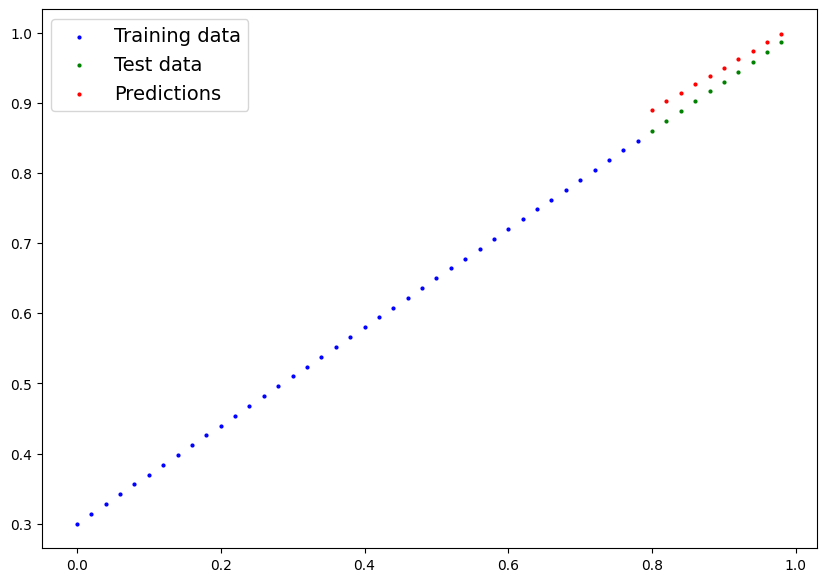

In [ ]:
plot_predictions(predictions=y_preds.cpu())

In [ ]:
from pathlib import Path

# 1. Create models directory
MODEL_PATH = Path("models")
MODEL_PATH.mkdir(parents=True, exist_ok=True)

# 2. Create model save path
MODEL_NAME = "01_pytorch_workflow_model_1.pth"
MODEL_SAVE_PATH = MODEL_PATH / MODEL_NAME

# 3. Save the model state dict
print(f"Saving model to: {MODEL_SAVE_PATH}")
torch.save(obj=model_1.state_dict(), # only saving the state_dict() only saves the models learned parameters
           f=MODEL_SAVE_PATH)

Saving model to: models/01_pytorch_workflow_model_1.pth


In [ ]:
# Instantiate a fresh instance of LinearRegressionModelV2
loaded_model_1 = LinearRegressionModelV2()

# Load model state dict
loaded_model_1.load_state_dict(torch.load(MODEL_SAVE_PATH))

# Put model to target device (if your data is on GPU, model will have to be on GPU to make predictions)
loaded_model_1.to(device)

print(f"Loaded model:\n{loaded_model_1}")
print(f"Model on device:\n{next(loaded_model_1.parameters()).device}")

Loaded model:
LinearRegressionModelV2(
  (linear_layer): Linear(in_features=1, out_features=1, bias=True)
)
Model on device:
cuda:0


In [ ]:
# Evaluate loaded model
loaded_model_1.eval()
with torch.inference_mode():
    loaded_model_1_preds = loaded_model_1(X_test)
y_preds == loaded_model_1_preds

tensor([[True],
        [True],
        [True],
        [True],
        [True],
        [True],
        [True],
        [True],
        [True],
        [True]], device='cuda:0')